In [ ]:
import json

with open('data/devpos.json') as f:
    devpos = json.load(f)
    

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [8]:
# Load the CSV file with your simulation results
df = pd.read_csv('data\dfdevc.csv')

# Display first few rows to verify
print(df.head())
print(f"Data shape: {df.shape}")


   Unnamed: 0   Time   tc1   tc2    tc3   tc4   tc5    tc6   tc7   tc8    tc9
0           0   0.00  20.0  20.0   20.0  20.0  20.0   20.0  20.0  20.0   20.0
1           1   5.01  20.0  20.0   20.0  20.0  20.0   20.0  20.0  20.0   20.0
2           2  10.00  20.2  20.2   21.3  20.1  20.1   21.8  20.3  20.2   21.5
3           3  15.00  20.5  25.5   61.4  20.4  21.0   56.6  20.6  26.0   64.7
4           4  20.00  20.9  24.4  120.0  20.8  21.7  109.0  20.9  24.1  119.0
Data shape: (121, 11)


In [9]:
# Define the physical (x, z) location of each thermocouple
# These come from your FDS input file (&DEVC XYZ=...)
tc_locations = {
    'tc1': (1.0, 0.0),   # x=1.0 m, z=0.0 m (bottom left)
    'tc2': (1.0, 1.0),   # x=1.0 m, z=1.0 m (mid left)
    'tc3': (1.0, 2.0),   # x=1.0 m, z=2.0 m (top left)
    'tc4': (2.5, 0.0),   # x=2.5 m, z=0.0 m (bottom center)
    'tc5': (2.5, 1.0),   # x=2.5 m, z=1.0 m (mid center)
    'tc6': (2.5, 2.0),   # x=2.5 m, z=2.0 m (top center)
    'tc7': (4.0, 0.0),   # x=4.0 m, z=0.0 m (bottom right)
    'tc8': (4.0, 1.0),   # x=4.0 m, z=1.0 m (mid right)
    'tc9': (4.0, 2.0),   # x=4.0 m, z=2.0 m (top right)
}
data_rows = []
for tc_name, (x, z) in tc_locations.items():
    for idx, row in df.iterrows():
        t = row['Time']           # Time in seconds
        T = row[tc_name]          # Temperature at this sensor
        data_rows.append([x, z, t, T])

# Create new DataFrame with columns: x, z, t, T
dataset = pd.DataFrame(data_rows, columns=['x', 'z', 't', 'T'])
print(f"Restructured dataset shape: {dataset.shape}")
print(dataset.head())

Restructured dataset shape: (1089, 4)
     x    z      t     T
0  1.0  0.0   0.00  20.0
1  1.0  0.0   5.01  20.0
2  1.0  0.0  10.00  20.2
3  1.0  0.0  15.00  20.5
4  1.0  0.0  20.00  20.9


In [13]:
# Get normalization parameters
x_max = 3.0          # Width of vent (4.0 - 1.0 = 3.0 m)
z_max = 2.0          # Height of vent
t_max = dataset['t'].max()    # Maximum simulation time
T_min = dataset['T'].min()    # Minimum temperature
T_max = dataset['T'].max()    # Maximum temperature

# Normalize all inputs and outputs to [0, 1] range
dataset['x_norm'] = dataset['x'] / x_max
dataset['z_norm'] = dataset['z'] / z_max
dataset['t_norm'] = dataset['t'] / t_max
dataset['T_norm'] = (dataset['T'] - T_min) / (T_max - T_min)

print(f"Original ranges: x:[0-{x_max}], z:[0-{z_max}], t:[0-{t_max}], T:[{T_min}-{T_max}]")
print("All normalized to [0,1] range")


Original ranges: x:[0-3.0], z:[0-2.0], t:[0-600.0], T:[20.0-566.0]
All normalized to [0,1] range


In [17]:
dataset.to_csv('data/dfdevc_norm.csv', index=False)

Epoch 1/8000 | Loss 1.4800e+01 | PDE 5.2949e-03 | Data 7.7825e-02 | alpha=-2.0191e-03
Epoch 200/8000 | Loss 8.1656e-01 | PDE 3.8961e-01 | Data 4.4099e-03 | alpha=-1.2928e-03
Epoch 400/8000 | Loss 3.3867e-01 | PDE 1.5315e-01 | Data 1.5040e-03 | alpha=-9.7804e-04
Epoch 600/8000 | Loss 4.7529e-01 | PDE 1.1387e-01 | Data 2.8933e-03 | alpha=-5.2014e-04
Epoch 800/8000 | Loss 2.0298e-01 | PDE 5.9224e-02 | Data 1.1724e-03 | alpha=-4.4195e-04
Epoch 1000/8000 | Loss 1.8817e-01 | PDE 5.2381e-02 | Data 1.6762e-03 | alpha=-4.2092e-04
Epoch 1200/8000 | Loss 1.4877e-01 | PDE 3.7647e-02 | Data 6.0001e-04 | alpha=-2.5774e-04
Epoch 1400/8000 | Loss 1.2669e-01 | PDE 2.7147e-02 | Data 1.4022e-03 | alpha=-3.8625e-04
Epoch 1600/8000 | Loss 1.0201e-01 | PDE 4.7315e-02 | Data 6.0195e-04 | alpha=-3.7050e-04
Epoch 1800/8000 | Loss 9.6137e-02 | PDE 3.0130e-02 | Data 2.3493e-04 | alpha=-2.6312e-04
Epoch 2000/8000 | Loss 8.8486e-02 | PDE 2.7326e-02 | Data 6.1198e-04 | alpha=-3.2457e-04
Epoch 2200/8000 | Loss 7.978

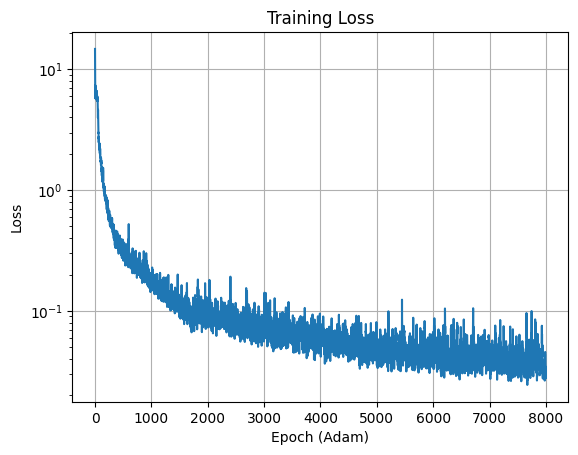

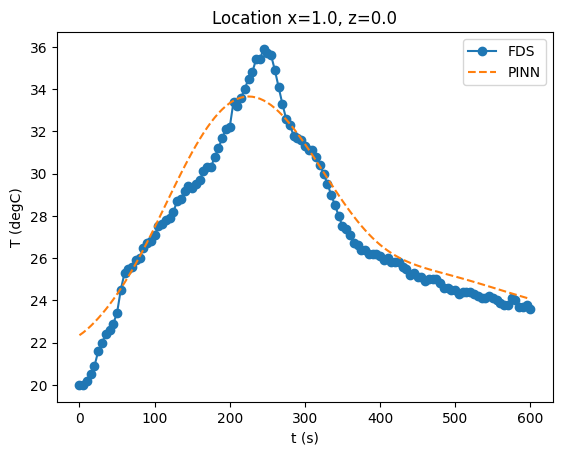

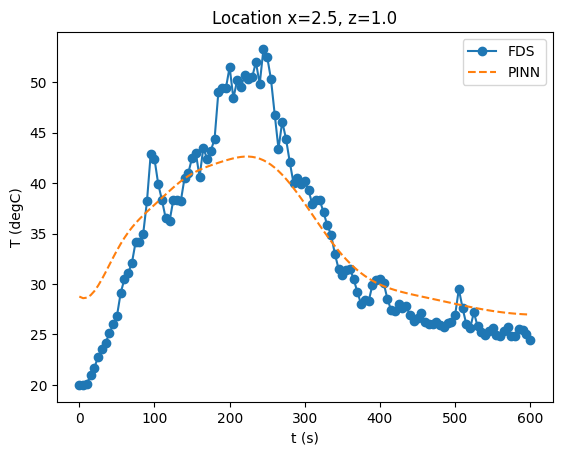

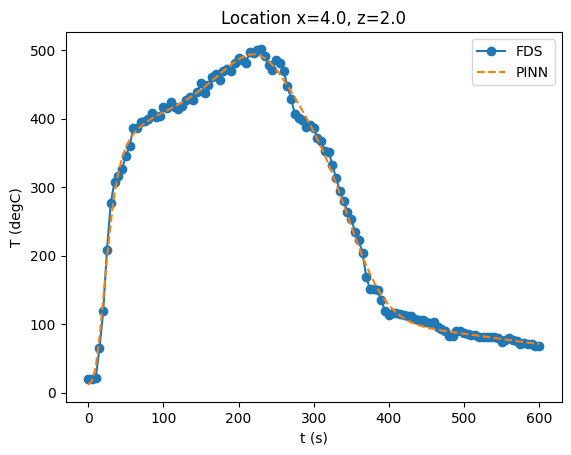

Done


In [18]:
"""
PINN for vent temperature learning from FDS thermocouple data
Domain: x in {1.0..4.0}, z in {0.0..2.0}, t in [0,600]
Data: CSV with columns: x,z,t,T

This script implements a supervised + physics-informed PINN for the 2D transient heat equation
u_t = alpha*(u_xx + u_zz) + Q (Q assumed zero here; can be learned)

Features:
- Loads CSV data (expects `fds_vent_data.csv` in working dir)
- Normalizes inputs/outputs
- Learnable thermal diffusivity `alpha` (optional to freeze)
- Collocation sampling inside domain
- Weighted losses: PDE residual, data, BC/IC (IC from t=0 rows if available)
- Adam training + optional LBFGS refinement
- Logging and simple plots (requires matplotlib)

Adjust hyperparams and file paths as needed.
"""

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------- User settings -------------------------
DATA_CSV = 'data\dfdevc_norm.csv'  # CSV path
USE_LEARNABLE_ALPHA = True      # learn thermal diffusivity
INITIAL_ALPHA = 1e-4            # initial guess (m^2/s)
T_FINAL = 600.0                 # total simulation time (s)

# Network architecture
LAYERS = [3, 128, 128, 128, 1]
ACT = torch.tanh

# Training hyperparams
N_EPOCHS_ADAM = 8000
BATCH_DATA = 512
N_COLLoc = 5000
W_PDE = 1.0
W_DATA = 100.0
W_BC = 50.0
W_IC = 50.0
LR = 1e-3

# Collocation domain bounds (set according to your vent domain)
X_MIN, X_MAX = 1.0, 4.0
Z_MIN, Z_MAX = 0.0, 2.0
T_MIN, T_MAX = 0.0, T_FINAL

# Save paths
MODEL_SAVE = 'pinn_fds_vent.pth'
LOG_INTERVAL = 200
PLOT_RESULTS = True
# -----------------------------------------------------------------

# ------------------------- Utilities ------------------------------
class PINN(nn.Module):
    def __init__(self, layers, act=ACT):
        super().__init__()
        self.act = act
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        # init
        for m in self.layers:
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: [N,3]
        z = x
        for layer in self.layers[:-1]:
            z = self.act(layer(z))
        out = self.layers[-1](z)
        return out


def sample_collocation(n):
    x = np.random.uniform(X_MIN, X_MAX, (n,1))
    z = np.random.uniform(Z_MIN, Z_MAX, (n,1))
    t = np.random.uniform(T_MIN, T_MAX, (n,1))
    X = np.hstack([x,z,t])
    return torch.tensor(X, dtype=torch.float32, device=device, requires_grad=True)

# normalization helpers
class Normalizer:
    def __init__(self, arr=None):
        if arr is not None:
            self.min = arr.min(axis=0)
            self.max = arr.max(axis=0)
        else:
            self.min = None
            self.max = None

    def fit(self, arr):
        self.min = arr.min(axis=0)
        self.max = arr.max(axis=0)
    def transform(self, arr):
        return (arr - self.min) / (self.max - self.min + 1e-12)
    def inverse(self, arr):
        return arr*(self.max - self.min + 1e-12) + self.min

# ------------------------- Data loading ---------------------------
if not os.path.exists(DATA_CSV):
    raise FileNotFoundError(f"CSV file '{DATA_CSV}' not found. Place your FDS thermocouple CSV in this path.")

df = pd.read_csv(DATA_CSV)
# Expect columns: x,z,t,T
for c in ['x','z','t','T']:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' missing from CSV")

# Convert to numpy
X_data = df[['x','z','t']].values.astype(np.float32)
Y_data = df[['T']].values.astype(np.float32)

# Fit normalizers
xnorm = Normalizer(); xnorm.fit(X_data)
ynorm = Normalizer(); ynorm.fit(Y_data)

Xn = xnorm.transform(X_data)
Yn = ynorm.transform(Y_data)

# Create data loader
dataset = TensorDataset(torch.tensor(Xn, dtype=torch.float32), torch.tensor(Yn, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=BATCH_DATA, shuffle=True)

# identify IC rows (t==0) and BC rows if available
ic_mask = np.isclose(X_data[:,2], T_MIN)
X_ic = Xn[ic_mask]
Y_ic = Yn[ic_mask]
has_ic = len(X_ic) > 0
if has_ic:
    X_ic_t = torch.tensor(X_ic, dtype=torch.float32, device=device, requires_grad=True)
    Y_ic_t = torch.tensor(Y_ic, dtype=torch.float32, device=device)

# ------------------------- Model setup ----------------------------
model = PINN(LAYERS).to(device)
if USE_LEARNABLE_ALPHA:
    alpha = torch.nn.Parameter(torch.tensor([INITIAL_ALPHA], dtype=torch.float32, device=device))
else:
    alpha = torch.tensor([INITIAL_ALPHA], dtype=torch.float32, device=device)

# optimizer
opt = torch.optim.Adam(list(model.parameters()) + ([alpha] if USE_LEARNABLE_ALPHA else []), lr=LR)

# PDE residual function
def pde_residual(xyzn):
    # z = model(xn) returns normalized temperature; we need to map back to physical T to compute PDE
    # but derivatives scale with normalization; easiest approach: compute PDE in physical space by
    # converting inputs and outputs using inverse transforms.
    xzn = xyn = xytn = xy = None
    # xyzn: normalized inputs [N,3]
    xyzn = xyzn.requires_grad_(True)
    Tn = model(xyzn).squeeze()  # normalized temperature

    # map normalized inputs to physical for derivative scaling
    # Let x_phys = xnorm.inverse(xn) etc; but autodiff through inverse is linear scaling, we can account for scale factors
    x_scale = (xnorm.max - xnorm.min + 1e-12)
    y_scale = x_scale[1]
    t_scale = x_scale[2]

    T_scale = (ynorm.max - ynorm.min + 1e-12)[0]

    # Compute dTn/dxn etc
    grads = torch.autograd.grad(Tn, xyzn, grad_outputs=torch.ones_like(Tn), create_graph=True)[0]
    dT_dn_x = grads[:,0]
    dT_dn_z = grads[:,1]
    dT_dn_t = grads[:,2]

    # convert to physical derivatives using chain rule: dT/dx = (dTn/dxn) * (dT_phys/dTn) * (dTn/dxn?)
    # Since Tn = (T - Tmin)/Trange => T = Tn*T_range + Tmin => dT/dTn = T_range
    # For x: xn = (x - xmin)/xrange => dx/dxn = xrange
    dx_dn = x_scale[0]
    dz_dn = x_scale[1]
    dt_dn = x_scale[2]

    # physical derivatives
    T_range = T_scale
    dT_dx = dT_dn_x * (T_range / dx_dn)
    dT_dz = dT_dn_z * (T_range / dz_dn)
    dT_dt = dT_dn_t * (T_range / dt_dn)

    # second derivatives
    d2T_dxn2 = torch.autograd.grad(dT_dn_x, xyzn, grad_outputs=torch.ones_like(dT_dn_x), create_graph=True)[0][:,0]
    d2T_dzn2 = torch.autograd.grad(dT_dn_z, xyzn, grad_outputs=torch.ones_like(dT_dn_z), create_graph=True)[0][:,1]

    d2T_dx2 = d2T_dxn2 * (T_range / (dx_dn**2))
    d2T_dz2 = d2T_dzn2 * (T_range / (dz_dn**2))

    # PDE residual in physical units: T_t - alpha*(T_xx + T_zz)
    res = dT_dt - alpha*(d2T_dx2 + d2T_dz2)
    return res

# ------------------------- Training loop --------------------------
loss_history = []
for epoch in range(1, N_EPOCHS_ADAM+1):
    model.train()
    total_loss = 0.0
    for Xb, Yb in loader:
        Xb = Xb.to(device)
        Yb = Yb.to(device)
        opt.zero_grad()

        # data loss (normalized)
        pred = model(Xb).squeeze()
        loss_data = torch.mean((pred - Yb.squeeze())**2)

        # PDE loss: sample collocation points (in normalized space)
        Xf = sample_collocation(N_COLLoc)
        Xf_n = torch.tensor(xnorm.transform(Xf.detach().cpu().numpy()), dtype=torch.float32, device=device, requires_grad=True)
        res = pde_residual(Xf_n)
        loss_pde = torch.mean(res**2)

        # IC loss if available
        loss_ic = torch.tensor(0.0, device=device)
        if has_ic:
            Xi = X_ic_t
            Yi = Y_ic_t
            pred_ic = model(Xi).squeeze()
            loss_ic = torch.mean((pred_ic - Yi.squeeze())**2)

        # BC loss: if you have explicit BC rows in data, they are included in data loss. Otherwise you can implement BC sampling here.
        loss = W_PDE*loss_pde + W_DATA*loss_data + W_IC*loss_ic
        loss.backward()
        opt.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)

    if epoch % LOG_INTERVAL == 0 or epoch == 1:
        a_val = alpha.item() if isinstance(alpha, torch.Tensor) or isinstance(alpha, torch.nn.Parameter) else float(alpha)
        print(f"Epoch {epoch}/{N_EPOCHS_ADAM} | Loss {avg_loss:.4e} | PDE {loss_pde.item():.4e} | Data {loss_data.item():.4e} | alpha={a_val:.4e}")

# Optional LBFGS refinement (uncomment to use; may be slow)
USE_LBFGS = True
if USE_LBFGS:
    print("Starting LBFGS refinement...")
    lbfgs_opt = torch.optim.LBFGS(list(model.parameters()) + ([alpha] if USE_LEARNABLE_ALPHA else []), max_iter=500, lr=1.0,
                                  tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        lbfgs_opt.zero_grad()
        # data loss on all data
        Xall = torch.tensor(Xn, dtype=torch.float32, device=device)
        Yall = torch.tensor(Yn, dtype=torch.float32, device=device)
        pred_all = model(Xall).squeeze()
        ld = torch.mean((pred_all - Yall.squeeze())**2)
        # PDE residual on collocation batch
        Xf = sample_collocation(N_COLLoc)
        Xf_n = torch.tensor(xnorm.transform(Xf.detach().cpu().numpy()), dtype=torch.float32, device=device, requires_grad=True)
        lr_pde = torch.mean(pde_residual(Xf_n)**2)
        loss = W_DATA*ld + W_PDE*lr_pde
        loss.backward()
        return loss

    lbfgs_opt.step(closure)

# Save model
torch.save({'model_state': model.state_dict(), 'alpha': alpha.detach().cpu().numpy(), 'xnorm_min': xnorm.min, 'xnorm_max': xnorm.max, 'ynorm_min': ynorm.min, 'ynorm_max': ynorm.max}, MODEL_SAVE)
print('Model saved to', MODEL_SAVE)

# ------------------------- Postprocess / plots --------------------
if PLOT_RESULTS:
    plt.figure()
    plt.semilogy(loss_history)
    plt.xlabel('Epoch (Adam)')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()

    # Plot predicted vs observed for a few sensor locations
    # pick 3 random thermocouples
    unique_pos = df[['x','z']].drop_duplicates().values
    sel = unique_pos[np.linspace(0, len(unique_pos)-1, min(3, len(unique_pos))).astype(int)]
    for (sx,sz) in sel:
        mask = (np.isclose(df['x'], sx)) & (np.isclose(df['z'], sz))
        times = df.loc[mask, 't'].values
        Tobs = df.loc[mask, 'T'].values
        Xq = np.vstack([np.full_like(times, sx), np.full_like(times, sz), times]).T
        Xq_n = xnorm.transform(Xq.astype(np.float32))
        with torch.no_grad():
            pred_n = model(torch.tensor(Xq_n, dtype=torch.float32, device=device)).cpu().numpy()
        pred_phys = ynorm.inverse(pred_n)
        plt.figure()
        plt.plot(times, Tobs, 'o-', label='FDS')
        plt.plot(times, pred_phys, '--', label='PINN')
        plt.xlabel('t (s)')
        plt.ylabel('T (degC)')
        plt.title(f'Location x={sx}, z={sz}')
        plt.legend()
        plt.show()

print('Done')


Generating predictions vs actual plots for all 9 sensors...
Sensor positions loaded from devpos.json


KeyError: 'Time'

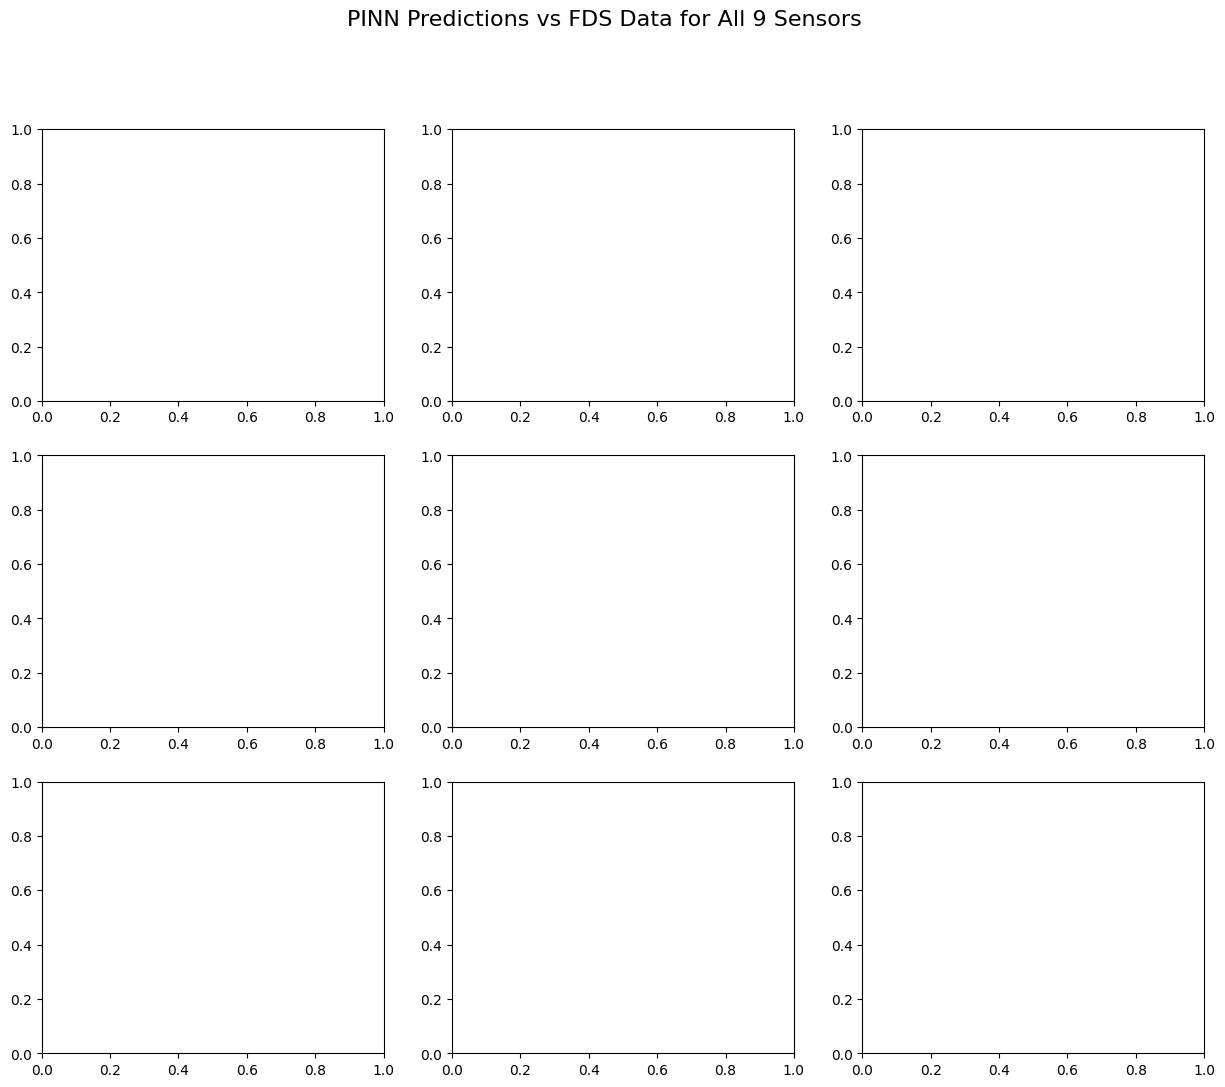

In [21]:
# ------------------------- Visualization for 9 Sensors --------------------
def plot_all_sensors_prediction_vs_actual(model, xnorm, ynorm, df, device):
    """
    Plot predicted vs actual temperature for all 9 sensors
    """
    import matplotlib.pyplot as plt
    
    # Get sensor positions from devpos.json
    try:
        import json
        with open('data/devpos.json', 'r') as f:
            sensor_positions = json.load(f)
        print("Sensor positions loaded from devpos.json")
    except:
        # Fallback: create dummy positions if file doesn't exist
        sensor_positions = {}
        for i in range(1, 10):
            sensor_positions[f'tc{i}'] = [1.0 + (i-1)*0.3, 0.5 + (i-1)*0.2]
        print("Using dummy sensor positions")
    
    # Create subplot grid: 3x3 for 9 sensors
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('PINN Predictions vs FDS Data for All 9 Sensors', fontsize=16)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    for i in range(9):
        sensor_name = f'tc{i+1}'
        ax = axes_flat[i]
        
        # Get sensor position - FIXED: positions are stored as [x, z] arrays
        if sensor_name in sensor_positions:
            x_pos = sensor_positions[sensor_name][0]  # First element is x
            z_pos = sensor_positions[sensor_name][1]  # Second element is z
        else:
            # Use dummy positions
            x_pos = 1.0 + i * 0.3
            z_pos = 0.5 + i * 0.2
        
        # Extract time series for this sensor
        times = df['Time'].values
        actual_temps = df[sensor_name].values
        
        # Create input array for predictions
        X_pred = np.column_stack([
            np.full_like(times, x_pos),  # x position
            np.full_like(times, z_pos),  # z position  
            times  # time
        ])
        
        # Normalize inputs
        X_pred_norm = xnorm.transform(X_pred.astype(np.float32))
        
        # Get predictions
        with torch.no_grad():
            pred_norm = model(torch.tensor(X_pred_norm, dtype=torch.float32, device=device))
            pred_norm = pred_norm.cpu().numpy()
        
        # Denormalize predictions
        pred_temps = ynorm.inverse(pred_norm).flatten()
        
        # Plot
        ax.plot(times, actual_temps, 'o-', label='FDS Data', markersize=3, linewidth=1.5)
        ax.plot(times, pred_temps, '--', label='PINN Prediction', linewidth=2)
        
        # Calculate and display RMSE
        rmse = np.sqrt(np.mean((actual_temps - pred_temps)**2))
        
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Temperature (°C)')
        ax.set_title(f'{sensor_name} (x={x_pos:.1f}, z={z_pos:.1f})\nRMSE: {rmse:.2f}°C')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Set consistent y-axis limits for better comparison
        all_temps = np.concatenate([actual_temps, pred_temps])
        y_min, y_max = np.min(all_temps), np.max(all_temps)
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS FOR ALL SENSORS")
    print("="*60)
    
    total_rmse = []
    for i in range(9):
        sensor_name = f'tc{i+1}'
        
        # Get sensor position - FIXED: positions are stored as [x, z] arrays
        if sensor_name in sensor_positions:
            x_pos = sensor_positions[sensor_name][0]  # First element is x
            z_pos = sensor_positions[sensor_name][1]  # Second element is z
        else:
            x_pos = 1.0 + i * 0.3
            z_pos = 0.5 + i * 0.2
        
        # Extract data
        times = df['Time'].values
        actual_temps = df[sensor_name].values
        
        # Get predictions
        X_pred = np.column_stack([
            np.full_like(times, x_pos),
            np.full_like(times, z_pos),
            times
        ])
        X_pred_norm = xnorm.transform(X_pred.astype(np.float32))
        
        with torch.no_grad():
            pred_norm = model(torch.tensor(X_pred_norm, dtype=torch.float32, device=device))
            pred_norm = pred_norm.cpu().numpy()
        
        pred_temps = ynorm.inverse(pred_norm).flatten()
        
        # Calculate metrics
        rmse = np.sqrt(np.mean((actual_temps - pred_temps)**2))
        mae = np.mean(np.abs(actual_temps - pred_temps))
        max_error = np.max(np.abs(actual_temps - pred_temps))
        
        total_rmse.append(rmse)
        
        print(f"{sensor_name:4s}: RMSE={rmse:6.2f}°C, MAE={mae:6.2f}°C, Max Error={max_error:6.2f}°C")
    
    print(f"\nOverall Average RMSE: {np.mean(total_rmse):.2f}°C")
    print(f"Overall RMSE Range: {np.min(total_rmse):.2f}°C - {np.max(total_rmse):.2f}°C")

# Call the visualization function
print("Generating predictions vs actual plots for all 9 sensors...")
plot_all_sensors_prediction_vs_actual(model, xnorm, ynorm, df, device)